In [1]:
import numpy as np
import pandas as pd
import scipy

In [2]:
from ecoevocrm.consumer_resource_system import *
from ecoevocrm.landscapes import *
import ecoevocrm.utils as utils
import ecoevocrm.viz as viz

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

#

# Model parameters

## Traits

In [4]:
num_resources = 10

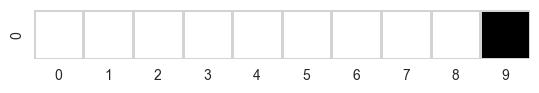

In [5]:
traits_init = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])
viz.matrix_plot(traits_init, vmin=0, cbar=False, linecolor='lightgray', linewidths=1)

In [6]:
mutation_rate = 1e-9

In [7]:
N_init = np.ones(traits_init.shape[0])
N_init

array([1.])

## Costs

In [8]:
cost_baseline = 0.1

In [9]:
cost_trait = 0.5

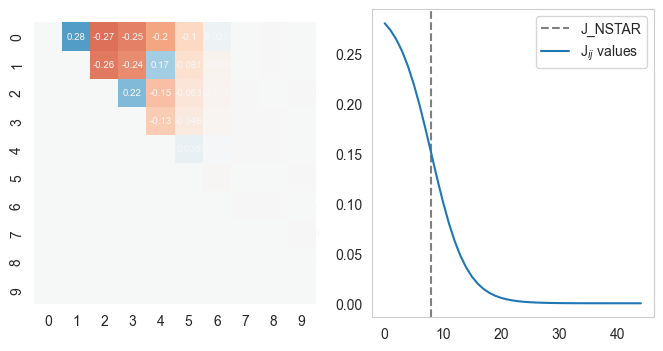

In [10]:
J_NSTAR = 8
J_SEED  = 1
#----------
J = utils.random_matrix((num_resources, num_resources), 'tikhonov_sigmoid_ordered', args={'J_0': 0.3, 'n_star': J_NSTAR, 'delta': 3}, triangular=True, diagonal=0, shuffle=False, order_power=0, seed=J_SEED)
#----------
fig, ax = plt.subplots(1, 2, figsize=(8, 4)) 
viz.matrix_plot(J, ax=ax[0], vmin=-0.5, vmax=0.5, cbar=False, annot=True, annot_kws={'size': 7, 'color': '#f7f7f7'})
ax[1].axvline(J_NSTAR, ls='--', color='gray', label='J_NSTAR')
ax[1].plot(range(len(J[J!=0])), np.sort(np.abs(J[J!=0]))[::-1], label="J${}_{ij}$ values")
ax[1].legend()

## Environment

In [11]:
ENV_SEED  = 1

In [12]:
T_adapt   = 2e5
T_persist = 2e6
T_total   = T_adapt + T_persist
dt_env    = 1e3

In [13]:
ENV_ETA_STD_adapt   = 0
ENV_ETA_STD_persist = 5e-9

In [14]:
# Adaption epoch
influx_series_adapt = utils.brownian_series(T=T_adapt, dt=dt_env, num_series=num_resources, return_interp=False, 
                                         eta_std=ENV_ETA_STD_adapt, eta_mean=0, lamda=1e-3, k=1e-8, y0=1, v0=0, seed=ENV_SEED)

In [15]:
# Persistence epoch
influx_series_persist = utils.brownian_series(T=T_persist, dt=dt_env, num_series=num_resources, return_interp=False, 
                                           eta_std=ENV_ETA_STD_persist, eta_mean=0, lamda=1e-3, k=1e-8, y0=1, v0=0, seed=10*ENV_SEED)

In [16]:
# Overall Environment
influx_series = scipy.interpolate.interp1d(np.hstack([influx_series_adapt[1], T_adapt+influx_series_persist[1]]), np.hstack([influx_series_adapt[0], influx_series_persist[0]]))

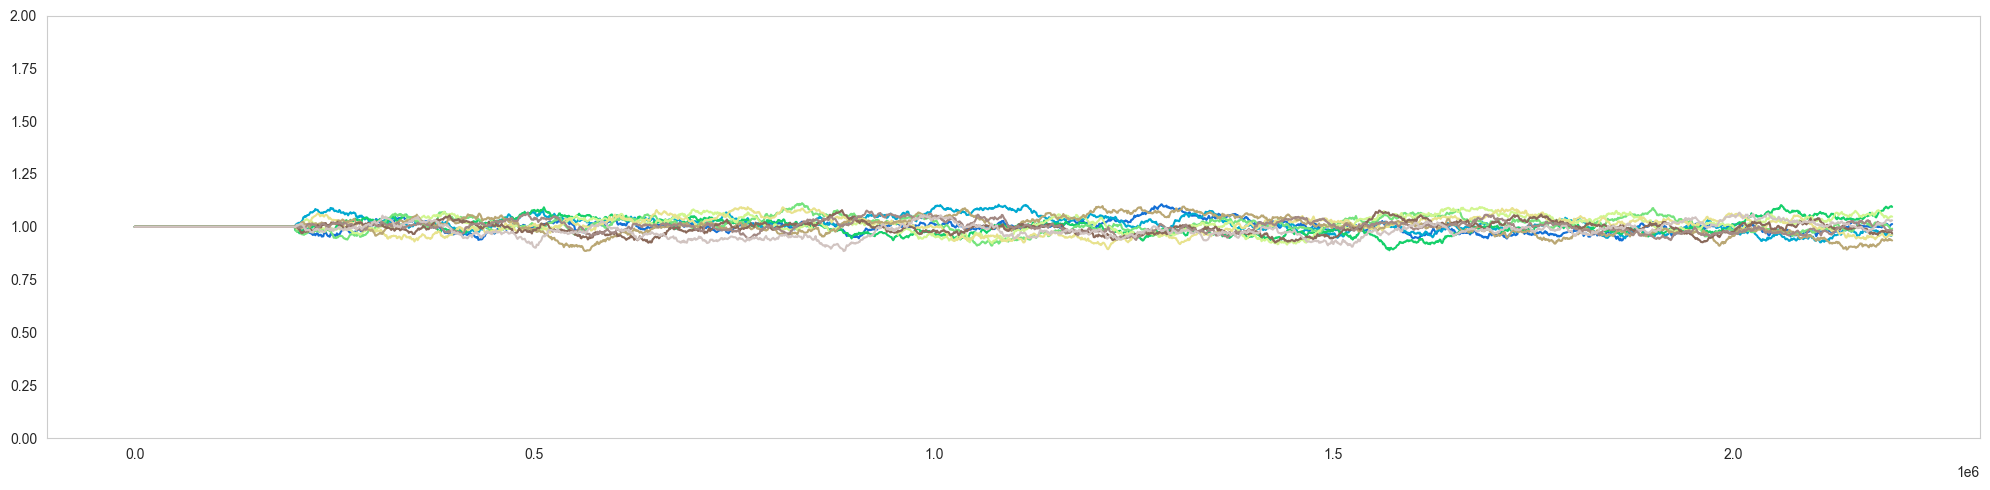

In [17]:
resource_colors = sns.color_palette('terrain', num_resources)
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
viz.interp_series_plot(influx_series, ax=ax, t_vals=np.arange(0, T_total, step=dt_env), colors=resource_colors)
ax.set_ylim(0, 2)
fig.tight_layout()

In [18]:
R_init = np.ones(num_resources)
# R_init

# Initialize model

In [19]:
SIM_SEED = 1

In [20]:
community = Community(traits=traits_init, cost_baseline=cost_baseline, cost_trait=cost_trait, cost_interaction=J, 
                      influx_rate=influx_series, N_init=N_init, R_init=R_init, seed=SIM_SEED)

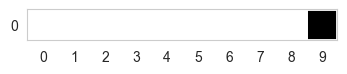

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(4, 10))
viz.attributes_plot(community.type_set, ax=ax, annot_alpha=0)

# Run model

In [22]:
community.run(T=T_total)

[ Mutant established at t=44.64 ]	0000000001 --> 1000000001
[ Mutant established at t=47.00 ]	0000000001 --> 1000000001
[ Mutant established at t=48.21 ]	0000000001 --> 0001000001
[ Mutant established at t=51.83 ]	0000000001 --> 0000001001
[ Mutant established at t=52.83 ]	0000000001 --> 1000000001
[ Mutant established at t=57.80 ]	0000000001 --> 0000010001
[ Mutant established at t=58.54 ]	0000000001 --> 0000000101
[ Mutant established at t=74.61 ]	1000000001 --> 1000010001
[ Mutant established at t=78.72 ]	0000000001 --> 0000100001
[ Mutant established at t=78.77 ]	1000000001 --> 1000000101
[ Mutant established at t=78.93 ]	0001000001 --> 0001000101
[ Mutant established at t=80.23 ]	1000000001 --> 1100000001
[ Mutant established at t=82.19 ]	0000000001 --> 0000010001
[ Mutant established at t=84.05 ]	0001000001 --> 0001010001
[ Mutant established at t=84.48 ]	1000000001 --> 1100000001
[ Mutant established at t=85.31 ]	1000000001 --> 1000000101
[ Mutant established at t=85.77 ]	100000

# Results

In [23]:
type_colors, _ = viz.type_styles_by_phylogeny(community.type_set, palette_depth=1, seed=1,
                                              color_step_start=0.2, color_step_slope=0.02,
                                              color_step_min=0.01, color_step_max=0.25, color_step_scale=1, color_step_dir='random')

<AxesSubplot: >

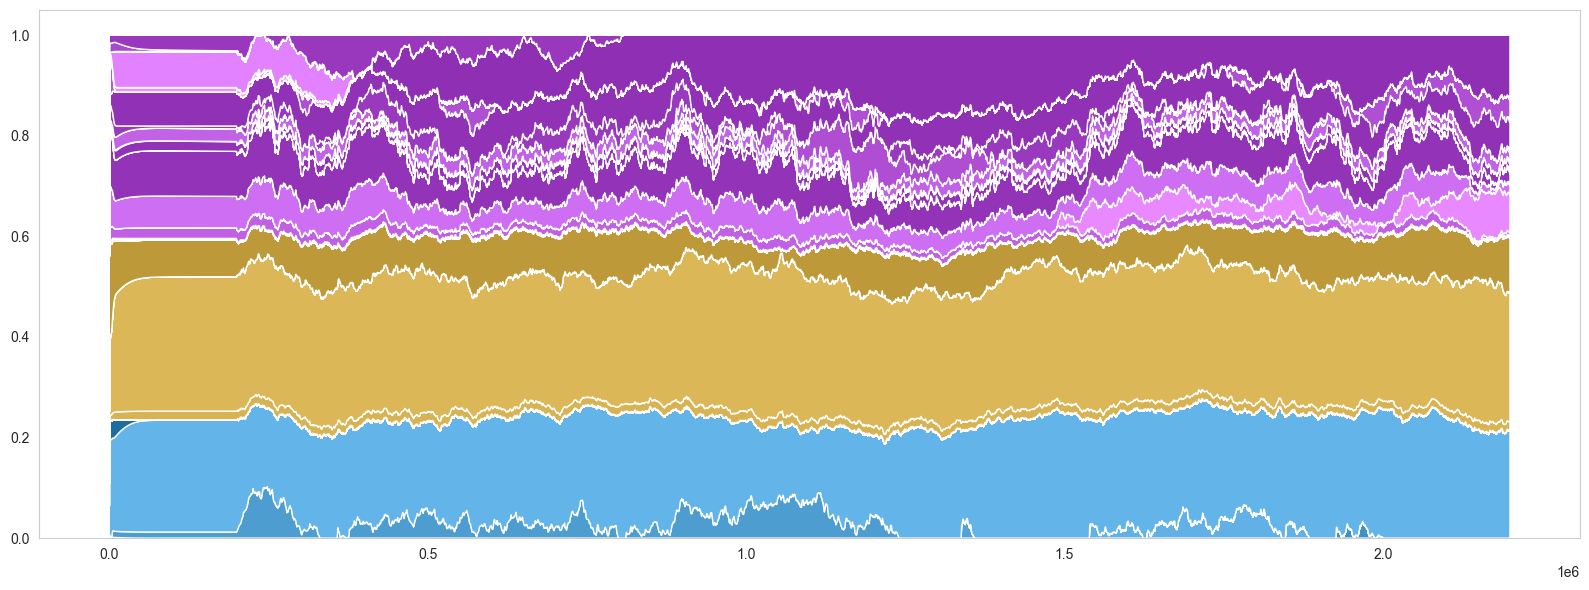

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
viz.abundance_plot(community, ax=ax, type_colors=type_colors, relative_abundance=True, stacked=True, baseline='sym', log_x_axis=False, palette_depth=1, t_min=30)

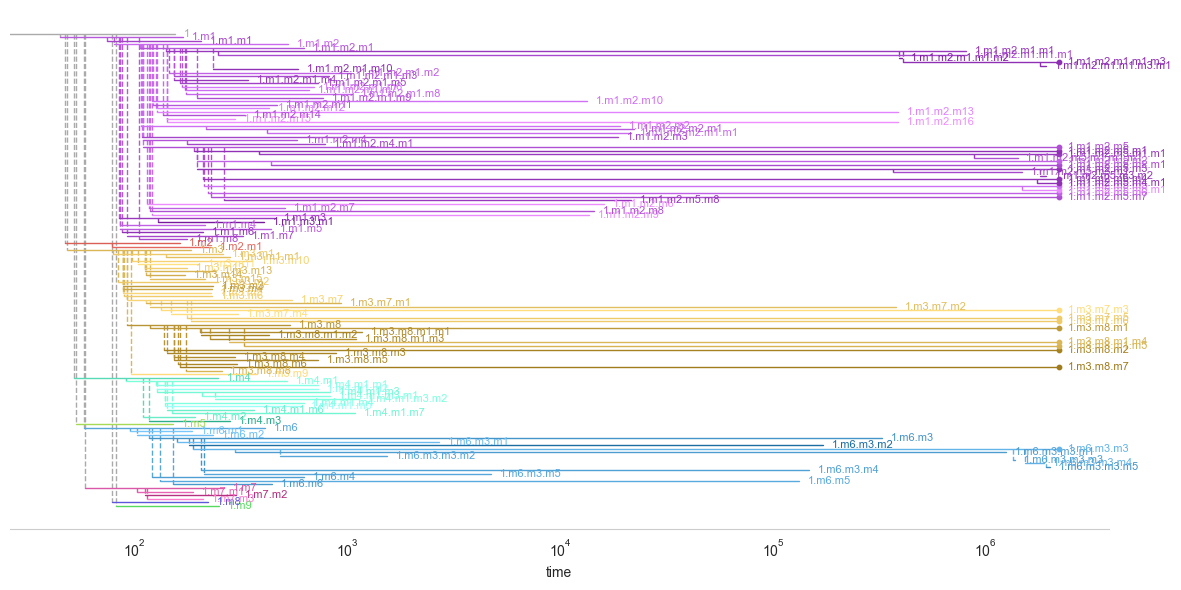

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
viz.phylogeny_plot(community, ax=ax, type_colors=type_colors, annot_lineageIDs=True, annot_traits=False, annot_extinct=True, annot_fontsize=8, log_x_axis=True)
# print(community.type_set.phylogeny)

In [26]:
# fig, ax = plt.subplots(1, 1, figsize=(12, 6))
# viz.resource_plot(community, ax=ax, stacked=True, relative=False, log_x_axis=True, log_y_axis=False)

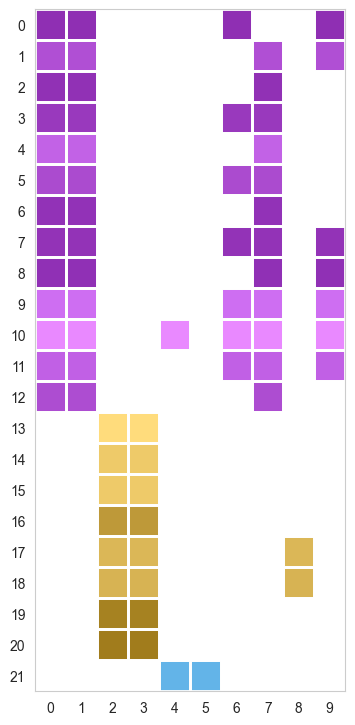

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(4, 10))
viz.attributes_plot(community.extant_type_set, ax=ax, type_colors=np.array(type_colors)[community.get_extant_type_indices()], annot_alpha=0)

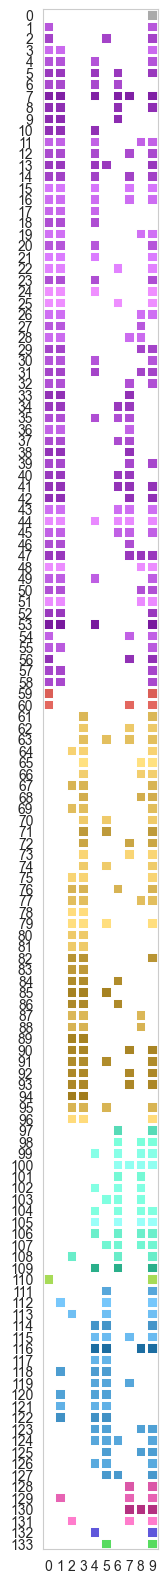

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(4, 20))
viz.attributes_plot(community.type_set, ax=ax, type_colors=type_colors, annot_alpha=0)